# TODO Titolo

## Initialization

### imports

Data download related

In [23]:
import os
from os import path   # system path
from os import mkdir  # create a directory
from glob import glob # query folders
import requests       # download
import zipfile        # extract zip files
from tqdm import tqdm # progress bar

Data manipulation

In [24]:
import geopandas as gpd # geo Pandas
import pandas as pd # Pandas
import matplotlib.pyplot as plt # to make graphs
import random # random
from shapely.geometry import Point, Polygon, MultiPolygon, LineString, MultiLineString # Funzione per generare punti casuali all'interno di un poligono # to deal with geometries

In [25]:
!pip install -q pyrosm
import pyrosm           # OSM Python parser

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 4.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


### Path to data

In [26]:
COLAB = None
try:
    # only for google drive linking (on Colab)
    from google.colab import drive
    # Link Google Drive account to use relative pathnames
    drive.mount("/content/gdrive", readonly = False)
    COLAB = True
except:
    COLAB = False
print("Notbook is running in Colab environment:", COLAB)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Notbook is running in Colab environment: True


In [27]:
#DATA_FOLDER = "/content/gdrive/MyDrive/Data Science/smart cities/data" # Edo Colab
DATA_FOLDER = "/content/gdrive/MyDrive/smart cities/data" # Davide Colab

## Datasets

Dictionary containing dataset urls, keys are dataset names.

In [28]:
datasets = {}

### Utility functions to download the datasets

Function to download and eventually extract a dataset in a folder given its URL.

In [29]:
def download_data(url, path=None):
  # download path
  if path is None:
    path = url.split('/')[-1]

  # download
  # stream = True necessary to read raw content
  print("Downloading", url)
  response = requests.get(url, stream = True)
  if response.status_code == 200:
    total_size = int(response.headers.get("content-length", 0))
    block_size = 1024
    with tqdm(total=total_size, unit="B", unit_scale=True) as progress_bar:
      with open(path, 'wb') as f:
        for chunk in response.iter_content(chunk_size = block_size):
          progress_bar.update(len(chunk))
          f.write(chunk)
  else:
    print("Warning: status code", response.status_code)
    return None

  # extract if necessary
  if path.endswith(".zip"):
    print("Unzipping", path)
    unzipped_folder = path.removesuffix(".zip")
    with zipfile.ZipFile(path, 'r') as zipf:
      zipf.extractall(unzipped_folder)
    return unzipped_folder
  else:
    return path

In [30]:
def filename_from_url(url):
  return url.split('/')[-1]

Functions to generate dataset paths, so that a dataset is always in the same place.

In [31]:
def dataset_folder(name):
  return path.join(DATA_FOLDER, name)

def dataset_path(name):
  urls = datasets[name]
  if type(urls) is list:
    return dataset_folder(name)
  else:
    return path.join(dataset_folder(name), filename_from_url(datasets[name]))

def dataset_paths(name):
  urls = datasets[name]
  if type(urls) is list:
    dfolder = dataset_folder(name)
    return [path.join(dfolder, filename_from_url(url)) for url in urls]
  else:
    return [path.join(dataset_folder(name), filename_from_url(datasets[name]))]

Function putting all the above together: downloads a dataset to the correct folder if it is not downloaded yet.

In [32]:
def download_project_data(name):
  dfolder = dataset_folder(name)
  # download if data is not already downloaded
  if path.exists(dfolder):
    print(f"'{name}' already downloaded")
  else:
    urls = datasets[name]
    # access before creating dir
    # if dict key error then does not create dir
    mkdir(dfolder)
    print(f"Getting dataset '{name}'")
    if type(urls) is list:
      for i, dpath in enumerate(dataset_paths(name)):
        download_data(urls[i], dpath)
    else:
      download_data(urls, dataset_path(name))

### Italy dataset

In [33]:
datasets["Italy_istat"] = "https://www.istat.it/storage/cartografia/confini_amministrativi/non_generalizzati/2024/Limiti01012024.zip"

In [34]:
download_project_data("Italy_istat")

'Italy_istat' already downloaded


In [35]:
ITALY_ISTAT_ROOT = dataset_folder("Italy_istat") + "/Italy_istatLimiti01012024/Limiti01012024"

In [36]:
macroregions = gpd.read_file(f"{ITALY_ISTAT_ROOT}/RipGeo01012024/RipGeo01012024_WGS84.shp")
macroregions.plot()
macroregions["dataset"] = "macroregion"
macroregions["entity"] = "territory"
macroregions["source"] = "istat"
macroregions

Output hidden; open in https://colab.research.google.com to view.

In [37]:
region = gpd.read_file(f"{ITALY_ISTAT_ROOT}/Reg01012024/Reg01012024_WGS84.shp")
region.plot()
region["dataset"] = "region"
region["entity"] = "territory"
region["source"] = "istat"
region.head()

Output hidden; open in https://colab.research.google.com to view.

In [38]:
def gdf_merge(gdfs):
  gdf_ref = gdfs[0]
  return pd.concat(
    [gdf.to_crs(gdf_ref.crs) for gdf in gdfs],
    ignore_index=True,
  )

def gplot_italy(gdf, column = "dataset", **kwargs):
  if (type(gdf) is list):
    return gplot_italy(gdf_merge(gdf), column = column, **kwargs)
  plot_gdf = gpd.GeoDataFrame(
    pd.concat([
      region,
      gdf.to_crs(region.crs),
    ], ignore_index=True),
    crs=region.crs,
  )
  return plot_gdf.plot(column = column, **kwargs)

COD_REG 3


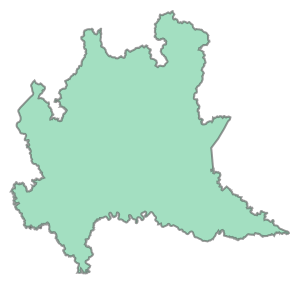

In [39]:
lombardia = region[region["DEN_REG"] == "Lombardia"].geometry.iloc[0]
lombardia_cod = region[region["DEN_REG"] == "Lombardia"].COD_REG.iloc[0]
print("COD_REG", lombardia_cod)
lombardia

COD_RIP  COD_REG  COD_PROV  COD_CM  COD_UTS  DEN_PROV  DEN_CM   DEN_UTS  \
0        1        1         1     201      201         -  Torino    Torino   
1        1        1         2       0        2  Vercelli       -  Vercelli   
2        1        1         3       0        3    Novara       -    Novara   
3        1        1         4       0        4     Cuneo       -     Cuneo   
4        1        1         5       0        5      Asti       -      Asti   

  SIGLA             TIPO_UTS     Shape_Leng    Shape_Area  \
0    TO  Città metropolitana  593230.438256  6.826930e+09   
1    VC            Provincia  458711.479193  2.081605e+09   
2    NO            Provincia  276706.922997  1.340248e+09   
3    CN            Provincia  542032.100362  6.894823e+09   
4    AT            Provincia  356340.593667  1.510173e+09   

                                            geometry   dataset     entity  \
0  POLYGON ((411015.294 5049971.205, 411070.286 5...  province  territory   
1  POLYGON ((437906.609 5088793.961, 437911.685 5...  province  territory   
2  POLYGON ((459146.455 5079451.255, 459180.781 5...  province  territory   
3  MULTIPOLYGON (((378934.647 4958535.662, 378939...  province  territory   
4  POLYGON ((423634.299 4998152.372, 423642.985 4...  province  territory   

  source  
0  istat  
1  istat  
2  istat  
3  istat  
4  istat

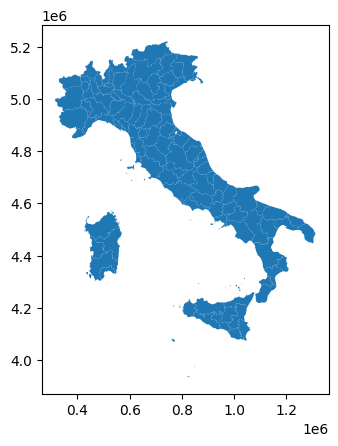

In [40]:
province = gpd.read_file(f"{ITALY_ISTAT_ROOT}/ProvCM01012024/ProvCM01012024_WGS84.shp")
province.plot()
province["dataset"] = "province"
province["entity"] = "territory"
province["source"] = "istat"
province.head()

In [41]:
def gplot_lombardia(gdf, column = "dataset", **kwargs):
  if (type(gdf) is list):
    return gplot_lombardia(gdf_merge(gdf), column = column, **kwargs)
  plot_gdf = gpd.GeoDataFrame(
    pd.concat([
      province[province["COD_REG"] == lombardia_cod],
      gdf.to_crs(province.crs),
    ], ignore_index=True),
    crs=province.crs,
  )
  return plot_gdf.plot(column = column, **kwargs)

COD_PROV 15


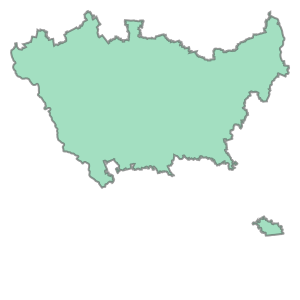

In [42]:
milano_province = province[province["SIGLA"] == "MI"].geometry.iloc[0]
milano_province_cod = province[province["SIGLA"] == "MI"].COD_PROV.iloc[0]
print("COD_PROV", milano_province_cod)
milano_province

COD_RIP  COD_REG  COD_PROV  COD_CM  COD_UTS  PRO_COM PRO_COM_T  \
0           1        1         1       0      201     1001    001001   
1           1        1         1       0      201     1002    001002   
2           1        1         1       0      201     1003    001003   
3           1        1         1       0      201     1004    001004   
4           1        1         1       0      201     1006    001006   
...       ...      ...       ...     ...      ...      ...       ...   
7894        5       20       111       0      111   111103    111103   
7895        5       20       111       0      111   111104    111104   
7896        5       20       111       0      111   111105    111105   
7897        5       20       111       0      111   111106    111106   
7898        5       20       111       0      111   111107    111107   

               COMUNE COMUNE_A  CC_UTS     Shape_Leng    Shape_Area  \
0               Agliè        0       0   18035.254001  1.314626e+07   
1             Airasca        0       0   18408.906988  1.573931e+07   
2        Ala di Stura        0       0   31834.156081  4.633156e+07   
3     Albiano d'Ivrea        0       0   18927.262827  1.173969e+07   
4              Almese        0       0   17057.413964  1.787412e+07   
...               ...      ...     ...            ...           ...   
7894       Villaputzu        0       0  110634.942651  1.813947e+08   
7895       Villasalto        0       0   61005.926286  1.303596e+08   
7896      Villasimius        0       0   62394.487906  5.817805e+07   
7897         Villasor        0       0   54680.040462  8.681369e+07   
7898    Villaspeciosa        0       0   33895.811188  2.719433e+07   

                                               geometry dataset     entity  \
0     POLYGON ((404703.561 5026682.656, 404733.562 5...  comune  territory   
1     POLYGON ((380700.909 4977305.520, 380702.627 4...  comune  territory   
2     POLYGON ((364710.856 5022090.677, 364725.872 5...  comune  territory   
3     POLYGON ((415942.510 5033304.612, 415962.885 5...  comune  territory   
4     POLYGON ((376934.550 4999073.855, 376941.551 4...  comune  territory   
...                                                 ...     ...        ...   
7894  MULTIPOLYGON (((556613.521 4375175.149, 556611...  comune  territory   
7895  POLYGON ((541186.146 4375105.652, 541180.146 4...  comune  territory   
7896  MULTIPOLYGON (((546444.097 4325894.052, 546443...  comune  territory   
7897  POLYGON ((500362.474 4361229.765, 500397.474 4...  comune  territory   
7898  POLYGON ((494131.525 4353208.830, 494183.525 4...  comune  territory   

     source  
0     istat  
1     istat  
2     istat  
3     istat  
4     istat  
...     ...  
7894  istat  
7895  istat  
7896  istat  
7897  istat  
7898  istat  

[7899 rows x 16 columns]

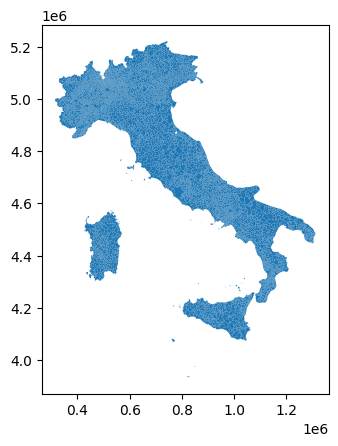

In [43]:
comune = gpd.read_file(f"{ITALY_ISTAT_ROOT}/Com01012024/Com01012024_WGS84.shp")
comune.plot()
comune["dataset"] = "comune"
comune["entity"] = "territory"
comune["source"] = "istat"
comune

In [44]:
def gplot_milano_province(gdf, column = "dataset", **kwargs):
  if (type(gdf) is list):
    return gplot_milano_province(gdf_merge(gdf), column = column, **kwargs)
  plot_gdf = gpd.GeoDataFrame(
    pd.concat([
      comune[comune["COD_PROV"] == milano_province_cod],
      gdf.to_crs(comune.crs),
    ], ignore_index=True),
    crs=comune.crs,
  )
  return plot_gdf.plot(column = column, **kwargs)

PRO_COM 15146


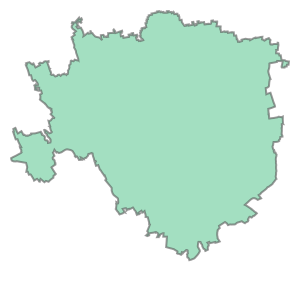

In [45]:
milano = comune[comune["COMUNE"] == "Milano"].geometry.iloc[0]
milano_cod = comune[comune["COMUNE"] == "Milano"].PRO_COM.iloc[0]
print("PRO_COM", milano_cod)
milano

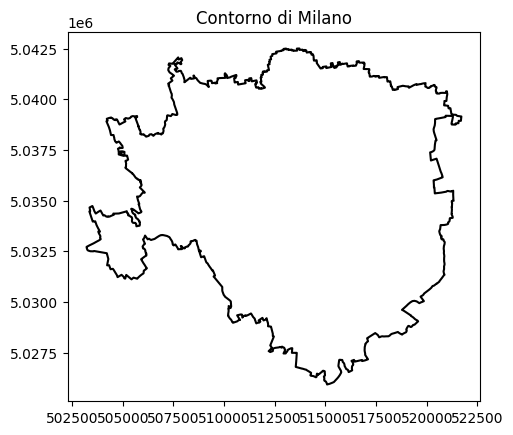

In [46]:
# Creazione di una GeoSeries contenente solo Milano
milano_geo = gpd.GeoSeries([milano])

# Plot del contorno della geometria
fig, ax = plt.subplots()
milano_geo.boundary.plot(ax=ax, edgecolor='black')

ax.set_title('Contorno di Milano')
plt.show()

In [47]:
def gplot_milano(gdf, column = "dataset", **kwargs):
  if (type(gdf) is list):
    return gplot_milano(gdf_merge(gdf), column = column, **kwargs)
  plot_gdf = gpd.GeoDataFrame(
    pd.concat([
      comune[comune["COMUNE"] == "Milano"].to_crs(epsg=32632),
      gdf.to_crs(epsg=32632),
    ], ignore_index=True),
    crs="epsg:32632",
  )
  return plot_gdf.plot(column = column, **kwargs)

In [48]:
def gplot_milano_border(gdf, **kwargs):
    if isinstance(gdf, list):
        return gplot_milano_border(gdf_merge(gdf), **kwargs)

    # Estrazione della geometria di Milano
    milano_gdf = comune[comune["COMUNE"] == "Milano"]

    # Creazione del GeoDataFrame con la geometria di Milano e i dati da plottare
    plot_gdf = gpd.GeoDataFrame(
        pd.concat([
            milano_gdf,
            gdf.to_crs(comune.crs)
        ], ignore_index=True),
        crs=comune.crs
    )

    # Plot del contorno di Milano
    ax = milano_gdf.boundary.plot(edgecolor='black', linewidth=2, **kwargs)

    # Plot delle altre geometrie sopra il contorno di Milano
    #plot_gdf.plot(ax=ax, **kwargs)

    # Aggiunta del titolo al plot
    ax.set_title('Contorno di Milano e dati aggiuntivi')

    plt.show()

### Air Quality Stations Comune Milano

In [49]:
datasets["Stations_Milano"] = "https://dati.comune.milano.it/dataset/d6960c75-0a02-4fda-a85f-3b1c4aa725d6/resource/635c6508-b335-48b1-b3c8-d43e78ad3380/download/qaria_stazione.geojson"

In [50]:
download_project_data("Stations_Milano")

'Stations_Milano' already downloaded


In [51]:
stations_milano = gpd.read_file(dataset_path("Stations_Milano")).to_crs(epsg=32632)
stations_milano["dataset"] = "stations_milano"
stations_milano["entity"] = "station"
stations_milano["source"] = "milano"
stations_milano["color"] = "blue"
stations_milano = stations_milano[stations_milano['inquinanti'].str.contains('PM10|PM25', case=False, na=False)]
# Convertire le colonne 'inizio_operativita' e 'fine_operativita' in formato datetime
stations_milano['inizio_operativita'] = pd.to_datetime(stations_milano['inizio_operativita'])
stations_milano['fine_operativita'] = pd.to_datetime(stations_milano['fine_operativita'])
# Filtrare le righe che comprendono il 2023
stations_milano = stations_milano[
    (stations_milano['inizio_operativita'] <= '2023-12-31') &
    (stations_milano['fine_operativita'] >= '2023-01-01')
]
stations_milano

id_amat          nome id_arpa inizio_operativita fine_operativita  \
1        2  via Pascal *     100         1900-01-01       2099-12-31   
3        4  viale Marche       2         1900-01-01       2099-12-31   
5        6  via Senato *     125         1900-01-01       2099-12-31   
6        7      Verziere      85         1900-01-01       2099-12-31   

                            inquinanti                        geometry  \
1  NO2, SO2, PM25, SO2, O3, PM10, C6H6  POINT (518351.042 5035645.702)   
3         C6H6, CO_8h, PM25, PM10, NO2  POINT (514910.677 5038103.127)   
5         PM25, PM10, C6H6, CO_8h, NO2  POINT (515470.916 5035238.303)   
6                 O3, PM10, NO2, CO_8h  POINT (515271.158 5034460.138)   

           dataset   entity  source color  
1  stations_milano  station  milano  blue  
3  stations_milano  station  milano  blue  
5  stations_milano  station  milano  blue  
6  stations_milano  station  milano  blue

<Axes: >

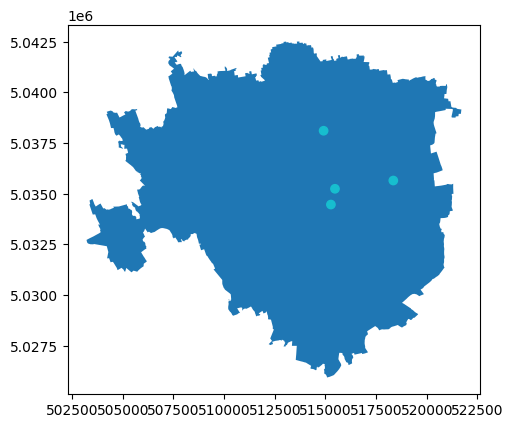

In [52]:
gplot_milano(stations_milano)

### Air Quality Comune Milano

In [53]:
datasets["Air_Milano"] = "https://dati.comune.milano.it/dataset/405ae1cd-0687-4449-baf2-6c9d993ed176/resource/d81b5f7d-20b8-4e3e-95cf-fbe3459dc1d2/download/qaria_datoariagiornostazione_2024-01-05.csv"

In [54]:
download_project_data("Air_Milano")

'Air_Milano' already downloaded


In [55]:
air_milano = pd.read_csv(
  dataset_path("Air_Milano"),
  sep=";",
)
air_milano.head()

stazione_id        data inquinante  valore
0            2  2023-12-29       C6H6     2.6
1            2  2023-12-29        NO2    49.0
2            2  2023-12-29         O3     5.0
3            2  2023-12-29       PM10     NaN
4            2  2023-12-29       PM25     NaN

In [56]:
print(air_milano["data"].min(), air_milano["data"].max())

2023-01-02 2023-12-29


In [57]:
conteggio_per_stazione = air_milano.groupby('stazione_id').size().reset_index(name='count')
conteggio_per_stazione

stazione_id  count
0            1    134
1            2   1452
2            3    439
3            4   1210
4            5    268
5            6   1210
6            7    726
7            8    402

In [58]:
air_milano = air_milano.pivot(index=['stazione_id', 'data'], columns='inquinante', values='valore').reset_index()
air_milano.index.name = None
air_milano

inquinante  stazione_id        data  C6H6  CO_8h  NO2  O3  PM10  PM25  SO2
0                     1  2023-01-02   NaN    NaN  NaN NaN   NaN   NaN  NaN
1                     1  2023-01-03   NaN    NaN  NaN NaN   NaN   NaN  NaN
2                     1  2023-01-04   NaN    NaN  NaN NaN   NaN   NaN  NaN
3                     1  2023-01-05   NaN    NaN  NaN NaN   NaN   NaN  NaN
4                     1  2023-01-09   NaN    NaN  NaN NaN   NaN   NaN  NaN
...                 ...         ...   ...    ...  ...  ..   ...   ...  ...
1607                  8  2023-07-10   NaN    NaN  NaN NaN   NaN   NaN  NaN
1608                  8  2023-07-11   NaN    NaN  NaN NaN   NaN   NaN  NaN
1609                  8  2023-07-12   NaN    NaN  NaN NaN   NaN   NaN  NaN
1610                  8  2023-07-13   NaN    NaN  NaN NaN   NaN   NaN  NaN
1611                  8  2023-07-14   NaN    NaN  NaN NaN   NaN   NaN  NaN

[1612 rows x 9 columns]

In [59]:
air_milano.drop("stazione_id", axis=1).notna().groupby(air_milano["stazione_id"], sort=False).sum().reset_index()

inquinante  stazione_id  data  C6H6  CO_8h  NO2   O3  PM10  PM25  SO2
0                     1   134     0      0    0    0     0     0    0
1                     2   242   240      0  238  234   235   235  242
2                     3   242     0    167  223    0     0     0    0
3                     4   242   234    230  225    0   235   234    0
4                     5   134     0      0    0    0     0     0    0
5                     6   242   214    220  233    0   224   223    0
6                     7   242     0      0  242  242   238     0    0
7                     8   134     0      0    0    0     0     0    0

In [60]:
air_milano = air_milano.drop(air_milano[air_milano["stazione_id"].isin([1, 5, 8])].index)

In [61]:
air_milano["C6H6_measurements"] = air_milano["C6H6"].notna()
air_milano["CO_8h_measurements"] = air_milano["CO_8h"].notna()
air_milano["NO2_measurements"] = air_milano["NO2"].notna()
air_milano["O3_measurements"] = air_milano["O3"].notna()
air_milano["PM10_measurements"] = air_milano["PM10"].notna()
air_milano["PM25_measurements"] = air_milano["PM25"].notna()
air_milano["SO2_measurements"] = air_milano["SO2"].notna()
air_milano["data"] = pd.to_datetime(air_milano["data"])
air_milano["month"] = air_milano["data"].dt.month
air_milano = air_milano.groupby(["stazione_id", "month"]).agg({
      "C6H6": "mean",
      "C6H6_measurements": "sum",
      "CO_8h": "mean",
      "CO_8h_measurements": "sum",
      "NO2": "mean",
      "NO2_measurements": "sum",
      "O3": "mean",
      "O3_measurements": "sum",
      "PM10": "mean",
      "PM10_measurements": "sum",
      "PM25": "mean",
      "PM25_measurements": "sum",
      "SO2": "mean",
      "SO2_measurements": "sum",
  })
air_milano = air_milano.reset_index()
air_milano.rename(columns={"PM25": "PM2,5", "PM25_measurements": "PM2,5_measurements"}, inplace=True)

### Air Quality Stations Lombardia

In [62]:
# datasets["Stations_Lombardia"] = "https://www.dati.lombardia.it/resource/9xaz-9vbz.json"
datasets["Stations_Lombardia"] = "https://www.dati.lombardia.it/resource/9xaz-9vbz.csv"

In [63]:
download_project_data("Stations_Lombardia")

'Stations_Lombardia' already downloaded


In [64]:
stations_lombardia = pd.read_csv(dataset_path("Stations_Lombardia"))
stations_lombardia = gpd.GeoDataFrame(
  stations_lombardia,
  geometry = gpd.points_from_xy(
    stations_lombardia.lng,
    stations_lombardia.lat,
  ),
  crs="EPSG:4326"
).to_crs(epsg=32632)
stations_lombardia["dataset"] = "stations_lombardia_1"
stations_lombardia["entity"] = "station"
stations_lombardia["source"] = "lombardia"
stations_lombardia.head()

idsensore    nometiposensore unitamisura  idstazione  \
0       5504  Biossido di Azoto       µg/m³         501   
1       5507  Biossido di Azoto       µg/m³         504   
2       5517  Biossido di Azoto       µg/m³         514   
3       5520  Biossido di Azoto       µg/m³         517   
4       5531  Biossido di Azoto       µg/m³         528   

                            nomestazione  quota provincia              comune  \
0                        Milano v.Marche  129.0        MI              Milano   
1  Sesto San Giovanni v. Cesare da Sesto  139.0        MI  Sesto San Giovanni   
2                      Rho via Buon Gesù  152.0        MI                 Rho   
3                                Turbigo  141.0        MI             Turbigo   
4                        Milano Verziere  116.0        MI              Milano   

   utm_nord  utm_est        lat       lng                        geometry  \
0   5038105   514918  45.496319  9.190934  POINT (514918.068 5038105.265)   
1   5042386   518435  45.534768  9.236109  POINT (518435.086 5042386.270)   
2   5041100   503483  45.523429  9.044602  POINT (503483.205 5041100.392)   
3   5041480   479423  45.526556  8.736502  POINT (479423.434 5041480.581)   
4   5034443   515270  45.463349  9.195325  POINT (515270.023 5034443.236)   

                dataset   entity     source  
0  stations_lombardia_1  station  lombardia  
1  stations_lombardia_1  station  lombardia  
2  stations_lombardia_1  station  lombardia  
3  stations_lombardia_1  station  lombardia  
4  stations_lombardia_1  station  lombardia

<Axes: >

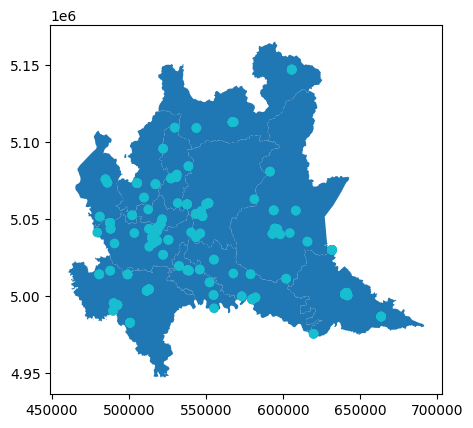

In [65]:
gplot_lombardia(stations_lombardia)

<Axes: >

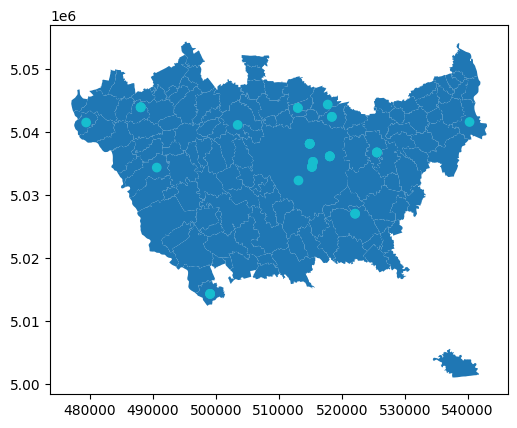

In [66]:
stations_lombardia_milano_province = stations_lombardia[stations_lombardia.to_crs(province.crs).within(milano_province)]
gplot_milano_province(stations_lombardia_milano_province)

<Axes: >

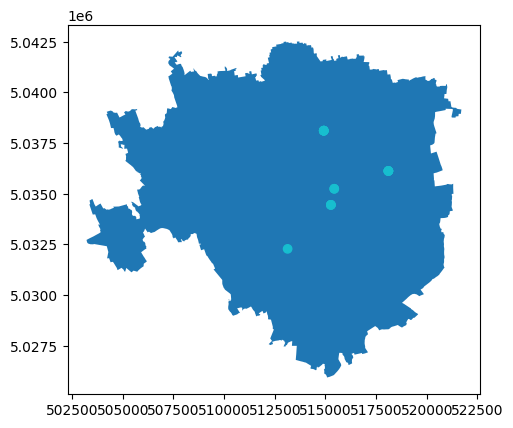

In [67]:
stations_lombardia_milano = stations_lombardia[stations_lombardia.to_crs(comune.crs).within(milano)]
gplot_milano(stations_lombardia_milano)

<Axes: >

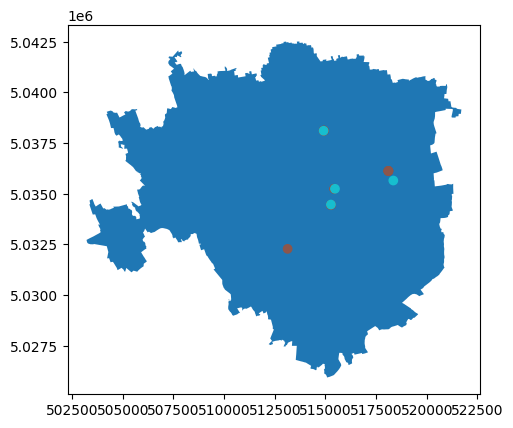

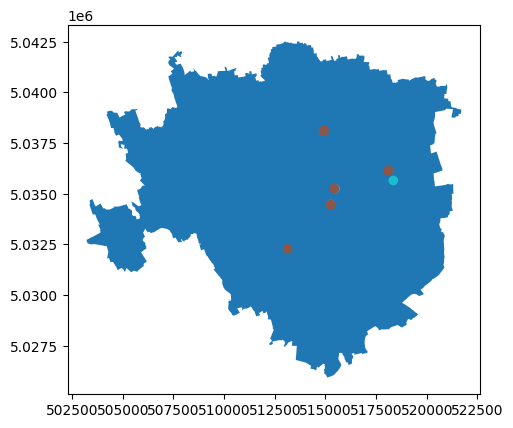

In [68]:
# print stations (Milano over Lombardia)
gplot_milano([stations_lombardia_milano, stations_milano])
# print stations (Lombardia over Milano)
gplot_milano([stations_milano, stations_lombardia_milano])

### Air Quality Stations Lombardia 2

In [69]:
datasets["Stations_Lombardia_2"] = "https://www.dati.lombardia.it/resource/ib47-atvt.json"

In [70]:
download_project_data("Stations_Lombardia_2")

'Stations_Lombardia_2' already downloaded


In [71]:
stations_lombardia_2 = pd.read_json(dataset_path("Stations_Lombardia_2"))
stations_lombardia_2 = gpd.GeoDataFrame(
  stations_lombardia_2,
  geometry = gpd.points_from_xy(
    stations_lombardia_2.lng,
    stations_lombardia_2.lat,
  ),
  crs="EPSG:4326"
).to_crs(epsg=32632)
stations_lombardia_2["dataset"] = "stations_lombardia_2"
stations_lombardia_2["entity"] = "station"
stations_lombardia_2["source"] = "lombardia"
stations_lombardia_2.head()

idsensore           nometiposensore unitamisura  idstazione  \
0      12691                  Arsenico       ng/m³         560   
1       5712                     Ozono       µg/m³         510   
2      20488  Particelle sospese PM2.5       µg/m³         564   
3      10043             PM10 (SM2005)       µg/m³         687   
4       6342           Ossidi di Azoto       µg/m³         515   

          nomestazione  quota provincia  comune storico  \
0     Varese v.Copelli  383.0        VA  Varese       N   
1  Inzago v.le Gramsci  138.0        MI  Inzago       S   
2     Erba v. Battisti  279.0        CO    Erba       N   
3       Ferno v.Di Dio  215.0        VA   Ferno       N   
4     Pero SS Sempione  141.0        MI    Pero       S   

                 datastart  ...       lng  \
0  2008-04-01T00:00:00.000  ...  8.820249   
1  2001-02-24T00:00:00.000  ...  9.486897   
2  2020-10-22T00:00:00.000  ...  9.221779   
3  2006-11-29T00:00:00.000  ...  8.756977   
4  1986-12-10T00:00:00.000  ...  9.089974   

                                            location  \
0  {'type': 'Point', 'coordinates': [8.82024911, ...   
1  {'type': 'Point', 'coordinates': [9.48689669, ...   
2  {'type': 'Point', 'coordinates': [9.2217792, 4...   
3  {'type': 'Point', 'coordinates': [8.75697656, ...   
4  {'type': 'Point', 'coordinates': [9.08997419, ...   

   :@computed_region_6hky_swhk  :@computed_region_ttgh_9sm5  \
0                          1.0                          1.0   
1                          4.0                          4.0   
2                          2.0                          2.0   
3                          1.0                          1.0   
4                          4.0                          4.0   

  :@computed_region_af5v_nc64                 datastop  \
0                         3.0                      NaN   
1                         8.0  2018-01-01T00:00:00.000   
2                         3.0                      NaN   
3                         3.0                      NaN   
4                         8.0  2018-07-30T00:00:00.000   

                         geometry               dataset   entity     source  
0  POINT (486035.653 5073728.139)  stations_lombardia_2  station  lombardia  
1  POINT (538012.883 5043030.084)  stations_lombardia_2  station  lombardia  
2  POINT (517232.000 5072802.999)  stations_lombardia_2  station  lombardia  
3  POINT (481053.478 5051773.415)  stations_lombardia_2  station  lombardia  
4  POINT (507028.169 5039595.375)  stations_lombardia_2  station  lombardia  

[5 rows x 23 columns]

<Axes: >

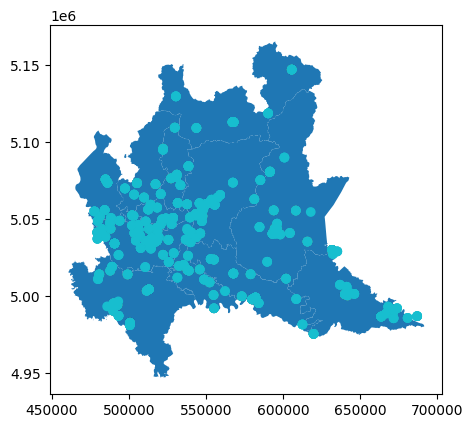

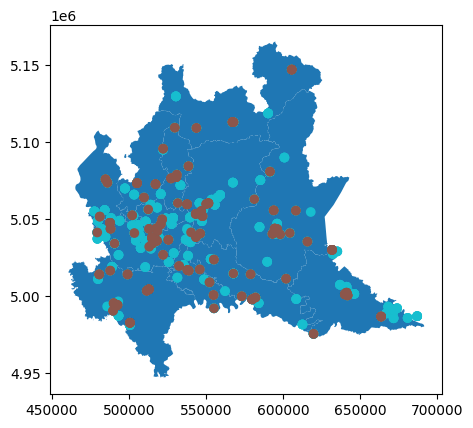

In [72]:
# print stations (Lombardia 2 over Lombardia)
gplot_lombardia([stations_lombardia, stations_lombardia_2])
# print stations (Lombardia over Lombardia 2)
gplot_lombardia([stations_lombardia_2, stations_lombardia])

<Axes: >

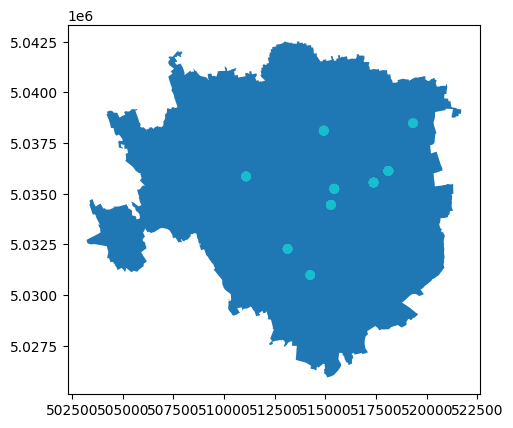

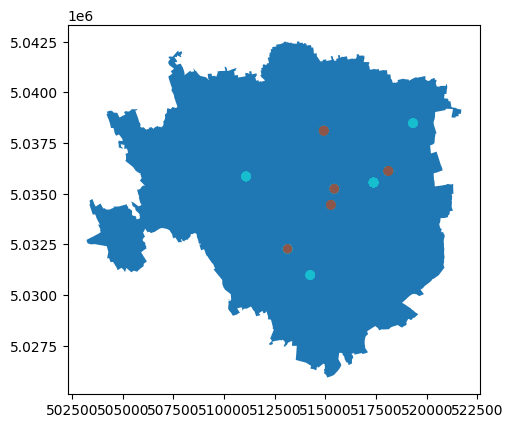

In [73]:
stations_lombardia_2_milano = stations_lombardia_2[stations_lombardia_2.to_crs(comune.crs).within(milano)]

# print stations (Lombardia 2 over Lombardia)
gplot_milano([stations_lombardia_milano, stations_lombardia_2_milano])
# print stations (Lombardia over Lombardia 2)
gplot_milano([stations_lombardia_2_milano, stations_lombardia_milano])

<Axes: >

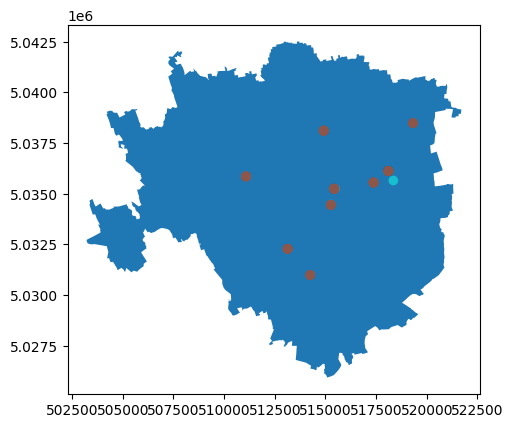

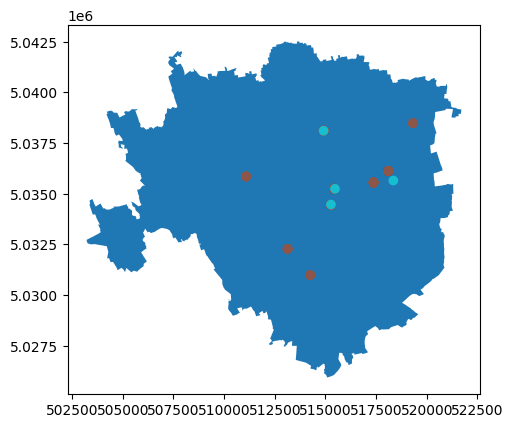

In [74]:
# print stations (Lombardia 2 over Milano)
gplot_milano([stations_milano, stations_lombardia_2_milano])
# print stations (Milano over Lombardia 2)
gplot_milano([stations_lombardia_2_milano, stations_milano])

### Air Quality Lombardia

In [75]:
#datasets["Air_Lombardia"] = "https://www.dati.lombardia.it/resource/ykhg-b8rs.json"
datasets["Air_Lombardia"] = "https://www.dati.lombardia.it/resource/ykhg-b8rs.csv"

Warning! from that link (official API) only the first 1000 rows are downloaded due to a rate limit. Get the complete data manually from this link and then sobstitute the file.

https://www.dati.lombardia.it/Ambiente/Dati-sensori-aria-NRT/ykhg-b8rs/data_preview

In [76]:
download_project_data("Air_Lombardia")

'Air_Lombardia' already downloaded


In [77]:
air_lombardia = pd.read_csv(dataset_path("Air_Lombardia"))
air_lombardia.head()

idSensore                 Data  Valore  idOperatore
0       5507  17/06/2024 01:00:00    14.0            1
1       5507  17/06/2024 02:00:00    12.0            1
2       5507  17/06/2024 03:00:00    13.0            1
3       5507  17/06/2024 04:00:00    13.0            1
4       5507  17/06/2024 05:00:00    15.0            1

In [78]:
print(air_lombardia["Data"].min(), air_lombardia["Data"].max())

17/06/2024 01:00:00 17/06/2024 14:00:00


### Open Street Maps Milano

In [79]:
datasets["OSM_Milano"] = "https://osmit-estratti.wmcloud.org/output/pbf/comuni/015146_Milano.osm.pbf"

In [80]:
download_project_data("OSM_Milano")

'OSM_Milano' already downloaded


In [81]:
osm_milano = pyrosm.OSM(dataset_path("OSM_Milano"))

In [82]:
osm_milano.conf.tags.available

['aerialway',
 'aeroway',
 'amenity',
 'boundary',
 'building',
 'craft',
 'emergency',
 'geological',
 'highway',
 'historic',
 'landuse',
 'leisure',
 'natural',
 'office',
 'power',
 'public_transport',
 'railway',
 'route',
 'place',
 'shop',
 'tourism',
 'waterway']

In [83]:
osm_milano.conf.tags.natural

['arete',
 'bare_rock',
 'bay',
 'beach',
 'cape',
 'cave_entrance',
 'cliff',
 'coastline',
 'dune',
 'fell',
 'geyser',
 'glacier',
 'grassland',
 'heath',
 'hill',
 'hot_spring',
 'isthmus',
 'moor',
 'mud',
 'natural',
 'peak',
 'peninsula',
 'reef',
 'ridge',
 'rock',
 'saddle',
 'sand',
 'scree',
 'scrub',
 'shingle',
 'sinkhole',
 'spring',
 'stone',
 'strait',
 'tree',
 'tree_row',
 'valley',
 'volcano',
 'water',
 'wetland',
 'wood']

In [84]:
osm_milano_natural = osm_milano.get_natural().to_crs(epsg=32632)
osm_milano_natural["dataset"] = "osm_milano_natural"
osm_milano_natural["entity"] = "natural"
osm_milano_natural["source"] = "osm"
osm_milano_natural["color"] = "forestgreen"
osm_milano_natural.head()

id        lat  changeset  version   timestamp visible       lon  \
0  461715328  45.490875        0.0        6  1696267867   False  9.134479   
1  761247282  45.464874        0.0        3  1408036318   False  9.203583   
2  935465497  45.437714        0.0        1  1286042622   False  9.154628   
3  935465525  45.437599        0.0        1  1286042622   False  9.154697   
4  935465528  45.437283        0.0        1  1286042622   False  9.153111   

                                                tags natural wetland  \
0  {"ele":"185","height":"50","name":"Monte Stell...    peak    None   
1   {"leaf_type":"broadleaved","species":"Magnolia"}    tree    None   
2                                               None    tree    None   
3                                               None    tree    None   
4                                               None    tree    None   

                         geometry osm_type water             dataset   entity  \
0  POINT (510508.077 5037491.566)     node   NaN  osm_milano_natural  natural   
1  POINT (515915.156 5034614.305)     node   NaN  osm_milano_natural  natural   
2  POINT (512093.888 5031588.334)     node   NaN  osm_milano_natural  natural   
3  POINT (512099.357 5031575.631)     node   NaN  osm_milano_natural  natural   
4  POINT (511975.307 5031540.218)     node   NaN  osm_milano_natural  natural   

  source        color  
0    osm  forestgreen  
1    osm  forestgreen  
2    osm  forestgreen  
3    osm  forestgreen  
4    osm  forestgreen

In [85]:
osm_milano_natural.crs

<Projected CRS: EPSG:32632>
Name: WGS 84 / UTM zone 32N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 6°E and 12°E, northern hemisphere between equator and 84°N, onshore and offshore. Algeria. Austria. Cameroon. Denmark. Equatorial Guinea. France. Gabon. Germany. Italy. Libya. Liechtenstein. Monaco. Netherlands. Niger. Nigeria. Norway. Sao Tome and Principe. Svalbard. Sweden. Switzerland. Tunisia. Vatican City State.
- bounds: (6.0, 0.0, 12.0, 84.0)
Coordinate Operation:
- name: UTM zone 32N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Axes: >

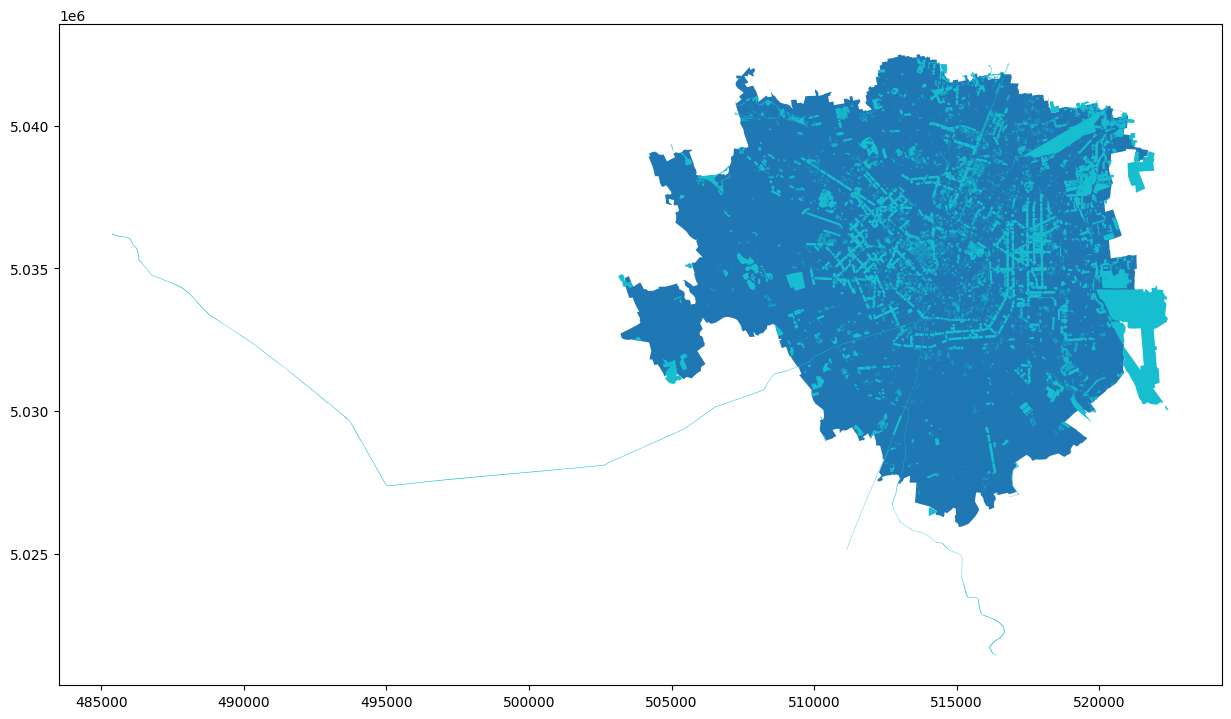

In [86]:
gplot_milano(osm_milano_natural, figsize=(15,15), markersize=0.01)

In [87]:
osm_milano_buildings = osm_milano.get_buildings().to_crs(epsg=32632)
osm_milano_buildings["dataset"] = "osm_milano_building"
osm_milano_buildings["entity"] = "building"
osm_milano_buildings["source"] = "osm"
osm_milano_buildings["color"] = "goldenrod"
osm_milano_buildings.head()

addr:city addr:country addr:housenumber addr:housename addr:postcode  \
0      None         None             None           None          None   
1      None         None             None           None          None   
2      None         None             None           None          None   
3      None         None             None           None          None   
4      None         None             None           None          None   

  addr:street email                          name opening_hours operator  ...  \
0        None  None  Chiesa di San Pietro in Sala          None     None  ...   
1        None  None              Teatro Nazionale          None     None  ...   
2        None  None          Milan Marriott Hotel          None     None  ...   
3        None  None                          None          None     None  ...   
4        None  None                          None          None     None  ...   

    timestamp version                                               tags  \
0  1696267868      13  {"denomination":"roman_catholic","religion":"c...   
1  1704187834      11  {"comment":"address was previously as Piazza P...   
2  1645194348      12       {"beds":"322","stars":"4","tourism":"hotel"}   
3  1707302584      11  {"denomination":"catholic","religion":"christi...   
4  1686217454      37                     {"layer":"2","min_height":"9"}   

  osm_type                                           geometry addr:place  \
0      way  POLYGON ((512223.542 5034992.969, 512228.300 5...        NaN   
1      way  POLYGON ((512053.946 5034796.422, 512022.478 5...        NaN   
2      way  POLYGON ((512034.768 5034143.732, 512035.326 5...        NaN   
3      way  POLYGON ((512239.439 5034332.718, 512219.402 5...        NaN   
4      way  POLYGON ((515865.527 5036965.860, 515857.507 5...        NaN   

  changeset              dataset    entity      color  
0       NaN  osm_milano_building  building  goldenrod  
1       NaN  osm_milano_building  building  goldenrod  
2       NaN  osm_milano_building  building  goldenrod  
3       NaN  osm_milano_building  building  goldenrod  
4       NaN  osm_milano_building  building  goldenrod  

[5 rows x 42 columns]

<Axes: >

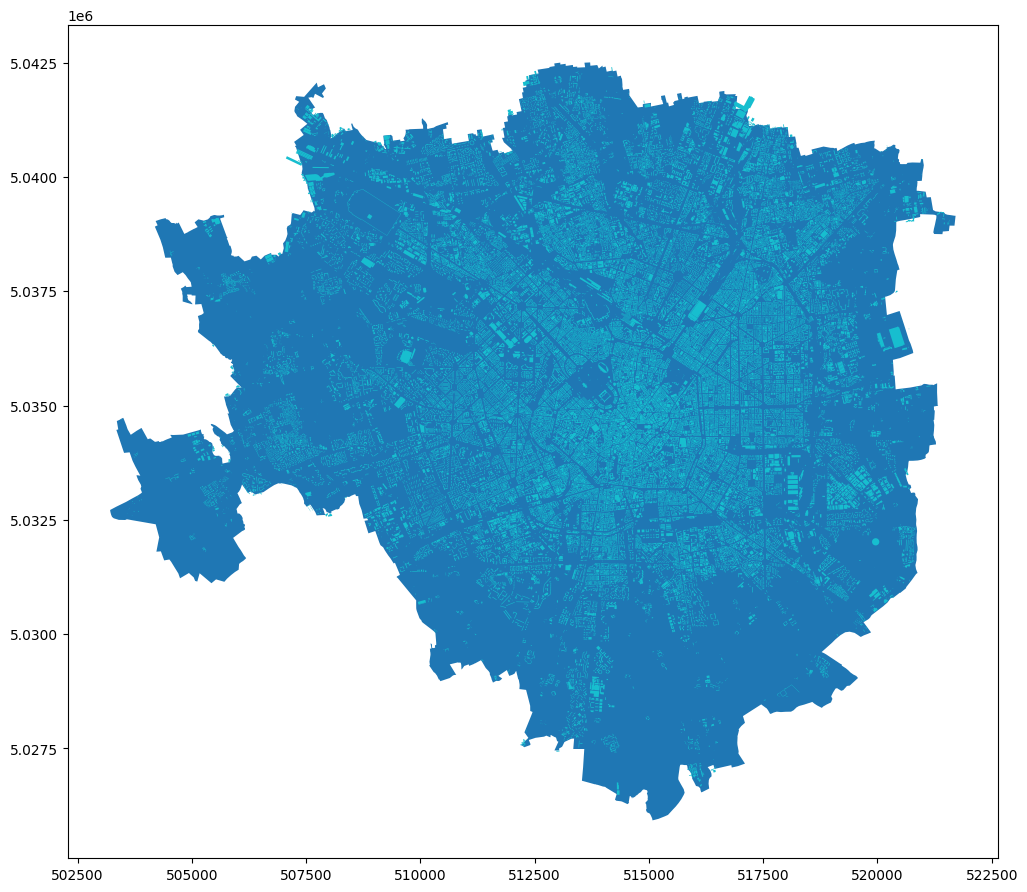

In [88]:
gplot_milano(osm_milano_buildings, figsize=(12,12))

In [89]:
osm_milano_buildings.shape[0]

61461

In [90]:
osm_milano_buildings['building:levels'].value_counts()

building:levels
5              3071
4              2995
1              2978
2              2436
3              2407
6              1739
7              1362
9              1009
8               903
10              162
11               63
17               38
12               33
13               28
15               19
14               18
18               17
16               11
4.5              10
19                9
3.5               8
0                 6
2.5               4
26                4
1.5               4
20                4
21                4
5.5               2
30                2
22                2
31                2
0.5               2
32                1
23                1
12345             1
44                1
50                1
37                1
43                1
27                1
piano terra       1
25                1
7.5               1
8.5               1
Name: count, dtype: int64

In [91]:
osm_milano_streets = osm_milano.get_network().to_crs(epsg=32632)
osm_milano_streets["dataset"] = "osm_milano_network"
osm_milano_streets["entity"] = "network"
osm_milano_streets["source"] = "osm"
osm_milano_streets["color"] = "firebrick"
osm_milano_streets.head()

access  area bicycle bicycle_road bridge busway cycleway est_width  foot  \
0   None  None    None         None   None   None     None      None  None   
1   None  None    None         None   None   None     None      None  None   
2   None  None    None         None   None   None     None      None  None   
3   None  None    None         None   None   None     None      None  None   
4   None  None    None         None   None   None     None      None  None   

  footway  ...   timestamp version  \
0    None  ...  1541879471       6   
1    None  ...  1704294789      13   
2    None  ...  1510248808      15   
3    None  ...  1681900795      10   
4    None  ...  1713854946      17   

                                                tags osm_type  \
0           {"visible":false,"loc_ref":"7238_35162"}      way   
1  {"visible":false,"cycleway:both":"no","lane_ma...      way   
2  {"visible":false,"incline":"down","loc_ref":"7...      way   
3  {"visible":false,"cycling_width":"mean","loc_r...      way   
4  {"visible":false,"cycleway:right":"no","loc_re...      way   

                                            geometry length  \
0  MULTILINESTRING ((513158.467 5035847.123, 5131...   32.0   
1  MULTILINESTRING ((511784.409 5034058.074, 5117...   50.0   
2  MULTILINESTRING ((513374.738 5035272.057, 5133...   72.0   
3  MULTILINESTRING ((511792.520 5034265.327, 5117...   89.0   
4  MULTILINESTRING ((511443.600 5036059.479, 5114...  139.0   

              dataset   entity source      color  
0  osm_milano_network  network    osm  firebrick  
1  osm_milano_network  network    osm  firebrick  
2  osm_milano_network  network    osm  firebrick  
3  osm_milano_network  network    osm  firebrick  
4  osm_milano_network  network    osm  firebrick  

[5 rows x 45 columns]

<Axes: >

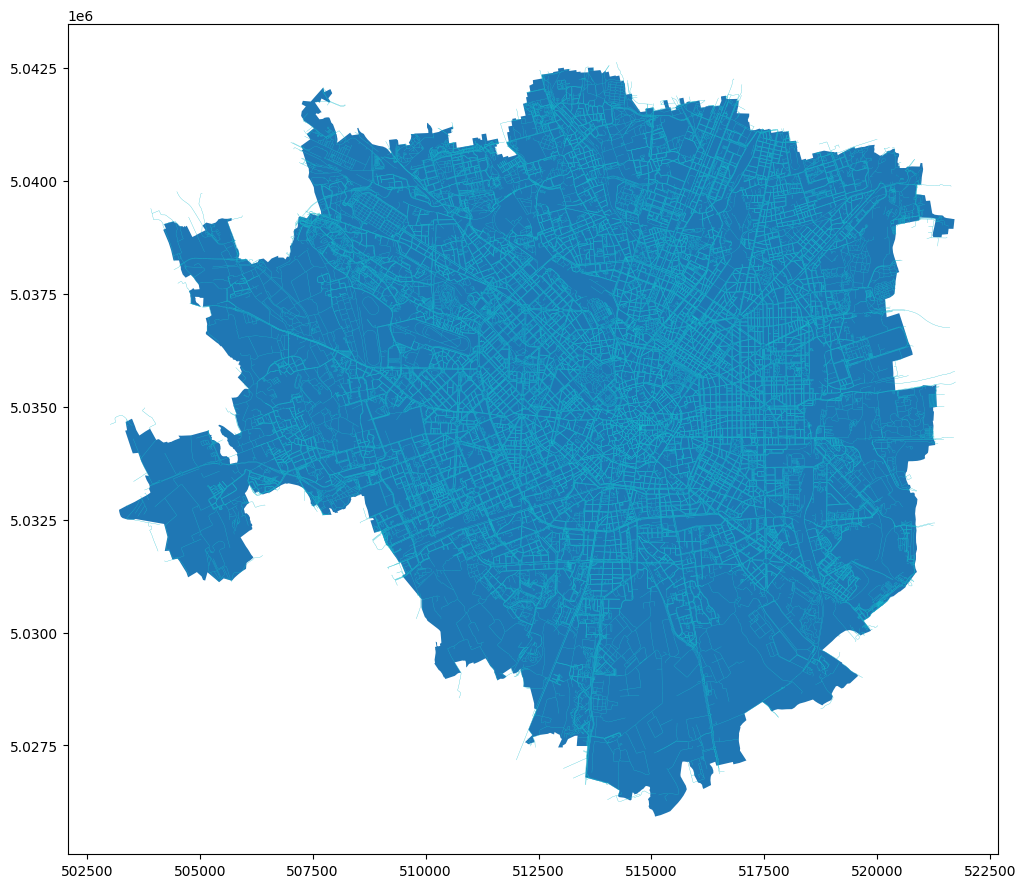

In [92]:
gplot_milano(osm_milano_streets, figsize=(12,12), linewidth=0.2)

In [93]:
def calcola_area_totale(gdf):
    gdf['area'] = gdf.geometry.area
    area_totale = gdf['area'].sum()
    return area_totale

area_totale_edifici = calcola_area_totale(osm_milano_buildings)
print(f"L'area totale degli edifici di Milano è: {area_totale_edifici} metri quadrati")

area_totale_elementi_naturali = calcola_area_totale(osm_milano_natural)
print(f"L'area totale degli elementi naturali di Milano è: {area_totale_elementi_naturali} metri quadrati")

L'area totale degli edifici di Milano è: 31666582.16443295 metri quadrati
L'area totale degli elementi naturali di Milano è: 16676775.571481159 metri quadrati


### Open Street Maps Milano province

In [94]:
datasets["OSM_Milano_Province"] = "https://osmit-estratti.wmcloud.org/output/pbf/province/015_Milano.osm.pbf"

In [95]:
download_project_data("OSM_Milano_Province")

'OSM_Milano_Province' already downloaded


In [96]:
# osm_milano_province = pyrosm.OSM(dataset_path("OSM_Milano_Province"))

In [97]:
# osm_milano_province_natural = osm_milano_province.get_natural().to_crs(epsg=32632)
# osm_milano_province_natural["dataset"] = "osm_milano_province_natural"
# osm_milano_province_natural["entity"] = "natural"
# osm_milano_province_natural["source"] = "osm"
# osm_milano_province_natural.head()

In [98]:
# gplot_milano_province(osm_milano_province_natural, figsize=(15,15), markersize=0.01)

### Open Street Maps Lombardia

In [99]:
datasets["OSM_Lombardia"] = "https://osmit-estratti.wmcloud.org/output/pbf/regioni/03_Lombardia.osm.pbf"

In [100]:
download_project_data("OSM_Lombardia")

'OSM_Lombardia' already downloaded


In [101]:
# osm_lombardia = pyrosm.OSM(dataset_path("OSM_Lombardia"))

In [102]:
# osm_lombardia_natural = osm_lombardia.get_natural().to_crs(epsg=32632)

In [103]:
# osm_lombardia_natural.plot()

### Sensor Community data

In [104]:
import datetime

Dataset obtained with the following manual steps

- Go to Sensor Community map to discover the sensors location (https://maps.sensor.community/#16/45.4635/9.1802)
- Reload the page multiple times to make a more reliable estimate of the position: precise sensor position is not disclosed
- Search the same place on Google maps, or other maps services that allows you to get the coordinates (on google maps right click in any point)
- If necessary, convert the coordinates (https://www.gps-coordinates.net/)

In [105]:
sc_base_url = "https://archive.sensor.community/"
sc_stations = pd.DataFrame([
    {
        "id": "#44216",
        "name": "Centro",
        "Latitude": "45.4617222",
        "Longitude": "9.182333333333332",
    },
    {
        "id": "#40256",
        "name": "Porta Vittoria",
        "Latitude": "45.462109495758476",
        "Longitude": "9.209781789416478",
    },
    {
        "id": "#32399",
        "name": "Via Meda",
        "Latitude": "45.43998127831078",
        "Longitude": "9.178070145718733",
    },
    {
        "id": "#70169",
        "name": "Lodi",
        "Latitude": "45.442101399035224",
        "Longitude": "9.21225714798778",
    },
    {
        "id": "#50128",
        "name": "Piazza Leonardo",
        "Latitude": "45.47777813047526",
        "Longitude": "9.224090852257673",
    },
    {
        "id": "#32393",
        "name": "Via Ripamonti Fine",
        "Latitude": "45.42612707777793",
        "Longitude": "9.20638203311217",
    },
    {
        "id": "#22851",
        "name": "Forlanini",
        "Latitude": "45.45989286059822",
        "Longitude": "9.239974456500574",
    },
    {
        "id": "#24644",
        "name": "Villapizzone",
        "Latitude": "45.50211369996133",
        "Longitude": "9.145822040967992",
    },
    # {
    #     "id": "#40645",
    #     "name": "Sesto Marelli",
    #     "Latitude": "45.5259435532775",
    #     "Longitude": "9.228986463143405",
    # },
    # {
    #     "id": "#57418",
    #     "name": "Corsico Via Matteotti",
    #     "Latitude": "45.43451533819612",
    #     "Longitude": "9.10707407551649",
    # }
])
sc_stations = gpd.GeoDataFrame(
  sc_stations,
  geometry = gpd.points_from_xy(
    sc_stations.Longitude,
    sc_stations.Latitude,
  ),
  crs="EPSG:4326"
).to_crs(epsg=32632)
sc_stations["dataset"] = "sc_chosen_stations"
sc_stations["entity"] = "station"
sc_stations["source"] = "sensor community"
sc_stations["color"] = "red"
sc_stations

id                name            Latitude          Longitude  \
0  #44216              Centro          45.4617222  9.182333333333332   
1  #40256      Porta Vittoria  45.462109495758476  9.209781789416478   
2  #32399            Via Meda   45.43998127831078  9.178070145718733   
3  #70169                Lodi  45.442101399035224   9.21225714798778   
4  #50128     Piazza Leonardo   45.47777813047526  9.224090852257673   
5  #32393  Via Ripamonti Fine   45.42612707777793   9.20638203311217   
6  #22851           Forlanini   45.45989286059822  9.239974456500574   
7  #24644        Villapizzone   45.50211369996133  9.145822040967992   

                         geometry             dataset   entity  \
0  POINT (514254.769 5034260.134)  sc_chosen_stations  station   
1  POINT (516400.569 5034308.395)  sc_chosen_stations  station   
2  POINT (513926.824 5031844.054)  sc_chosen_stations  station   
3  POINT (516599.959 5032086.080)  sc_chosen_stations  station   
4  POINT (517514.386 5036052.144)  sc_chosen_stations  station   
5  POINT (516145.039 5030310.204)  sc_chosen_stations  station   
6  POINT (518761.742 5034068.738)  sc_chosen_stations  station   
7  POINT (511392.183 5038741.671)  sc_chosen_stations  station   

             source color  
0  sensor community   red  
1  sensor community   red  
2  sensor community   red  
3  sensor community   red  
4  sensor community   red  
5  sensor community   red  
6  sensor community   red  
7  sensor community   red

<Axes: >

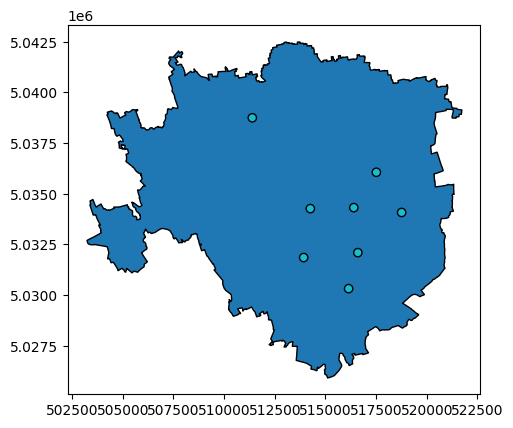

In [106]:
gplot_milano(sc_stations, edgecolor = 'black')

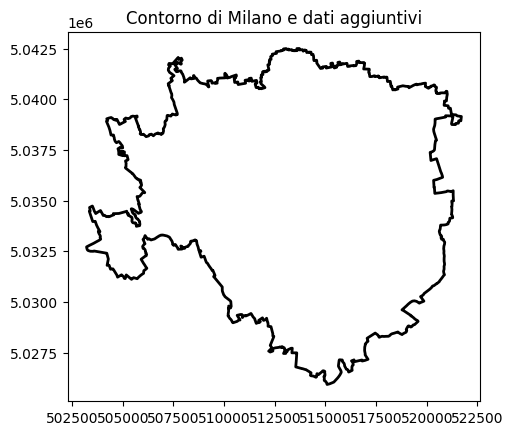

In [107]:
gplot_milano_border(sc_stations)

<Axes: >

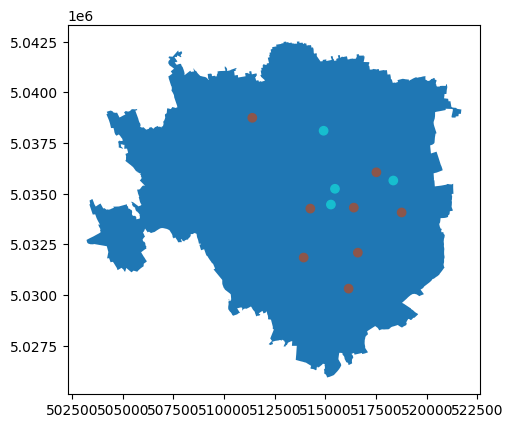

In [108]:
sc_stations["entity"] = "station_sc"

gplot_milano([sc_stations, stations_milano])

In [109]:
def sc_station_to_filename(id, date):
  return date.strftime("%Y-%m-%d") + f"_sds011_sensor_{id}.csv"

def sc_url_gen(stationId):
  if stationId.startswith("#"):
    stationId = stationId[1:]
  current = datetime.date(2023, 1, 1)
  while current.year < 2024:
    yield sc_base_url + current.strftime("%Y-%m-%d") + "/" + sc_station_to_filename(stationId, current)
    current += datetime.timedelta(days=1)

In [110]:
for station_id in sc_stations["id"]:
  name = f"SensorCommunity_station{station_id}"
  datasets[name] = []
  for u in sc_url_gen(station_id):
    datasets[name].append(u)

In [111]:
def pd_read_csvs(folder, **kwargs):
  csv_files = glob(path.join(folder, "*.csv"))
  df_out = None
  for f in csv_files:
      df = pd.read_csv(f, **kwargs)
      if df_out is None:
        df_out = df
      else:
        df_out = pd.concat([df_out, df])
  return df_out

In [112]:
def air_sc_by_month(air_sc_df):
  air_sc_df["timestamp"] = pd.to_datetime(air_sc_df["timestamp"])
  sensor_id = air_sc_df["sensor_id"].iloc[0]
  sensor_type = air_sc_df["sensor_type"].iloc[0]
  location = air_sc_df["location"].iloc[0]
  lat = air_sc_df["lat"].iloc[0]
  lon = air_sc_df["lon"].iloc[0]
  air_sc_df["P1_measurements"] = air_sc_df["P1"].notna()
  air_sc_df["P2_measurements"] = air_sc_df["P2"].notna()
  air_sc_df = air_sc_df.groupby(air_sc_df["timestamp"].dt.month).agg({
      "P1": "mean",
      "P1_measurements": "sum",
      "P2": "mean",
      "P2_measurements": "sum",
  })
  air_sc_df = air_sc_df.reset_index().rename(columns={"timestamp": "month"})
  air_sc_df["sensor_id"] = sensor_id
  air_sc_df["sensor_type"] = sensor_type
  air_sc_df["location"] = location
  air_sc_df["lat"] = lat
  air_sc_df["lon"] = lon
  return air_sc_df

In [113]:
download_project_data("SensorCommunity_station#44216")

'SensorCommunity_station#44216' already downloaded


In [114]:
air_sc_44216 = pd_read_csvs(dataset_path("SensorCommunity_station#44216"), sep=";")
air_sc_44216.head()

sensor_id sensor_type  location        lat       lon            timestamp  \
0      44216      SDS011     29885  45.461683  9.182103  2023-01-01T00:01:07   
1      44216      SDS011     29885  45.461683  9.182103  2023-01-01T00:03:34   
2      44216      SDS011     29885  45.461683  9.182103  2023-01-01T00:06:10   
3      44216      SDS011     29885  45.461683  9.182103  2023-01-01T00:08:38   
4      44216      SDS011     29885  45.461683  9.182103  2023-01-01T00:11:04   

       P1  durP1  ratioP1      P2  durP2  ratioP2  
0  432.02    NaN      NaN  324.35    NaN      NaN  
1  457.00    NaN      NaN  344.48    NaN      NaN  
2  425.02    NaN      NaN  327.17    NaN      NaN  
3  405.25    NaN      NaN  307.42    NaN      NaN  
4  403.83    NaN      NaN  305.98    NaN      NaN

In [115]:
air_sc_44216 = air_sc_by_month(air_sc_44216)
air_sc_44216

month         P1  P1_measurements         P2  P2_measurements  sensor_id  \
0       1  30.730758            13490  20.968428            13490      44216   
1       2  35.931124            13856  23.128715            13856      44216   
2       3  20.303564            12872  14.347259            12872      44216   
3       4   9.433302             6593   7.428934             6593      44216   
4       5   9.086172            17712   7.302746            17712      44216   
5       6   9.048480            17005   7.353428            17005      44216   
6       7  10.828957            16829   7.907772            16829      44216   
7       8   8.623264            17623   6.705236            17623      44216   
8       9  13.355141            17163  10.390339            17163      44216   
9      10  24.957386            16707  17.892725            16707      44216   
10     11  17.371174            16251  12.832739            16251      44216   
11     12  34.972535            17409  24.432113            17409      44216   

   sensor_type  location        lat       lon  
0       SDS011     29885  45.461683  9.182103  
1       SDS011     29885  45.461683  9.182103  
2       SDS011     29885  45.461683  9.182103  
3       SDS011     29885  45.461683  9.182103  
4       SDS011     29885  45.461683  9.182103  
5       SDS011     29885  45.461683  9.182103  
6       SDS011     29885  45.461683  9.182103  
7       SDS011     29885  45.461683  9.182103  
8       SDS011     29885  45.461683  9.182103  
9       SDS011     29885  45.461683  9.182103  
10      SDS011     29885  45.461683  9.182103  
11      SDS011     29885  45.461683  9.182103

In [116]:
download_project_data("SensorCommunity_station#40256")

'SensorCommunity_station#40256' already downloaded


In [117]:
air_sc_40256 = air_sc_by_month(pd_read_csvs(dataset_path("SensorCommunity_station#40256"), sep=";"))
air_sc_40256.head()

month         P1  P1_measurements         P2  P2_measurements  sensor_id  \
0      1  23.375402            14930  12.813699            14930      40256   
1      3  11.307066            10649   6.258918            10649      40256   
2      4   6.538949            16799   4.255543            16799      40256   
3      5   5.739817            17828   3.995803            17828      40256   
4      6   5.787205             8507   3.801868             8507      40256   

  sensor_type  location     lat   lon  
0      SDS011     25977  45.462  9.21  
1      SDS011     25977  45.462  9.21  
2      SDS011     25977  45.462  9.21  
3      SDS011     25977  45.462  9.21  
4      SDS011     25977  45.462  9.21

In [118]:
download_project_data("SensorCommunity_station#32399")

'SensorCommunity_station#32399' already downloaded


In [119]:
air_sc_32399 = air_sc_by_month(pd_read_csvs(dataset_path("SensorCommunity_station#32399"), sep=";"))
air_sc_32399.head()

month         P1  P1_measurements         P2  P2_measurements  sensor_id  \
0      1  33.100388            15632  21.724093            15632      32399   
1      2  44.452998            12940  28.543417            12940      32399   
2      4   7.637358              299   4.287692              299      32399   
3      5  10.483874            17385   6.666878            17385      32399   
4      6  10.404030            14577   6.380929            14577      32399   

  sensor_type  location    lat    lon  
0      SDS011     45045  45.44  9.178  
1      SDS011     45045  45.44  9.178  
2      SDS011     45045  45.44  9.178  
3      SDS011     45045  45.44  9.178  
4      SDS011     45045  45.44  9.178

In [120]:
download_project_data("SensorCommunity_station#70169")

'SensorCommunity_station#70169' already downloaded


In [121]:
air_sc_70169 = air_sc_by_month(pd_read_csvs(dataset_path("SensorCommunity_station#70169"), sep=";"))
air_sc_70169.head()

month         P1  P1_measurements         P2  P2_measurements  sensor_id  \
0      1  33.600594            13173  16.085085            13173      70169   
1      2  37.614765            11869  17.144691            11869      70169   
2      3  18.959902            13237   9.816070            13237      70169   
3      4  11.127652            13576   6.098490            13576      70169   
4      5  10.014274            14271   5.954106            14271      70169   

  sensor_type  location     lat    lon  
0      SDS011     57543  45.442  9.212  
1      SDS011     57543  45.442  9.212  
2      SDS011     57543  45.442  9.212  
3      SDS011     57543  45.442  9.212  
4      SDS011     57543  45.442  9.212

In [122]:
download_project_data("SensorCommunity_station#50128")

'SensorCommunity_station#50128' already downloaded


In [123]:
air_sc_50128 = air_sc_by_month(pd_read_csvs(dataset_path("SensorCommunity_station#50128"), sep=";"))
air_sc_50128.head()

month         P1  P1_measurements         P2  P2_measurements  sensor_id  \
0      1  33.168649            14043  18.230861            14043      50128   
1      2  37.209948            12617  19.951162            12617      50128   
2      3  19.137770            13155  11.342087            13155      50128   
3      4  11.270879            13533   6.853956            13533      50128   
4      5  12.764668            13234   9.048013            13234      50128   

  sensor_type  location     lat    lon  
0      SDS011     36026  45.478  9.224  
1      SDS011     36026  45.478  9.224  
2      SDS011     36026  45.478  9.224  
3      SDS011     36026  45.478  9.224  
4      SDS011     36026  45.478  9.224

In [124]:
download_project_data("SensorCommunity_station#32393")

'SensorCommunity_station#32393' already downloaded


In [125]:
air_sc_32393 = air_sc_by_month(pd_read_csvs(dataset_path("SensorCommunity_station#32393"), sep=";"))
air_sc_32393.head()

month         P1  P1_measurements         P2  P2_measurements  sensor_id  \
0      1  39.298709            15748  25.220344            15748      32393   
1      2  47.145809            14019  29.019295            14019      32393   
2      3  22.605537            15920  14.845758            15920      32393   
3      4  13.289923            16798   8.967069            16798      32393   
4      5  11.404370            17782   8.221495            17782      32393   

  sensor_type  location     lat    lon  
0      SDS011     18853  45.426  9.206  
1      SDS011     18853  45.426  9.206  
2      SDS011     18853  45.426  9.206  
3      SDS011     18853  45.426  9.206  
4      SDS011     18853  45.426  9.206

In [126]:
download_project_data("SensorCommunity_station#22851")

'SensorCommunity_station#22851' already downloaded


In [127]:
air_sc_22851 = air_sc_by_month(pd_read_csvs(dataset_path("SensorCommunity_station#22851"), sep=";"))
air_sc_22851.head()

month         P1  P1_measurements         P2  P2_measurements  sensor_id  \
0      1  41.660364            15619  20.074076            15619      22851   
1      2  48.270240            14067  22.092649            14067      22851   
2      3  23.228121            15947  11.846846            15947      22851   
3      4  11.867915            16706   6.515221            16706      22851   
4      5  10.504171            16714   6.476937            16714      22851   

  sensor_type  location    lat   lon  
0      SDS011     11592  45.46  9.24  
1      SDS011     11592  45.46  9.24  
2      SDS011     11592  45.46  9.24  
3      SDS011     11592  45.46  9.24  
4      SDS011     11592  45.46  9.24

In [128]:
download_project_data("SensorCommunity_station#24644")

'SensorCommunity_station#24644' already downloaded


In [129]:
air_sc_24644 = air_sc_by_month(pd_read_csvs(dataset_path("SensorCommunity_station#24644"), sep=";"))
air_sc_24644.head()

month         P1  P1_measurements         P2  P2_measurements  sensor_id  \
0      1  41.764563            15941  19.515888            15941      24644   
1      2  53.900088            14386  22.943497            14385      24644   
2      3  26.382369            16232  12.381585            16232      24644   
3      4  13.565327            16952   6.703951            16952      24644   
4      5  12.134428            17869   6.718724            17869      24644   

  sensor_type  location     lat    lon  
0      SDS011     12780  45.502  9.146  
1      SDS011     12780  45.502  9.146  
2      SDS011     12780  45.502  9.146  
3      SDS011     12780  45.502  9.146  
4      SDS011     12780  45.502  9.146

In [130]:
air_sc = pd.concat([air_sc_44216, air_sc_40256, air_sc_32399, air_sc_70169, air_sc_50128, air_sc_32393, air_sc_22851, air_sc_24644])
air_sc = air_sc.rename(columns={
    "P1": "PM10",
    "P1_measurements": "PM10_measurements",
    "P2": "PM2,5",
    "P2_measurements": "PM2,5_measurements",
})
air_sc

month       PM10  PM10_measurements      PM2,5  PM2,5_measurements  \
0       1  30.730758              13490  20.968428               13490   
1       2  35.931124              13856  23.128715               13856   
2       3  20.303564              12872  14.347259               12872   
3       4   9.433302               6593   7.428934                6593   
4       5   9.086172              17712   7.302746               17712   
..    ...        ...                ...        ...                 ...   
7       8  10.817017              17678   5.345783               17678   
8       9  18.767835              17403   9.800872               17403   
9      10  32.411993              17769  16.315359               17769   
10     11  23.425089              17406  11.833916               17406   
11     12  46.679825              18006  22.467319               18006   

    sensor_id sensor_type  location        lat       lon  
0       44216      SDS011     29885  45.461683  9.182103  
1       44216      SDS011     29885  45.461683  9.182103  
2       44216      SDS011     29885  45.461683  9.182103  
3       44216      SDS011     29885  45.461683  9.182103  
4       44216      SDS011     29885  45.461683  9.182103  
..        ...         ...       ...        ...       ...  
7       24644      SDS011     12780  45.502000  9.146000  
8       24644      SDS011     12780  45.502000  9.146000  
9       24644      SDS011     12780  45.502000  9.146000  
10      24644      SDS011     12780  45.502000  9.146000  
11      24644      SDS011     12780  45.502000  9.146000  

[94 rows x 10 columns]

In [131]:
stations_milano = stations_milano.rename(columns={'nome': 'name', 'id_amat': 'id'})
stations_milano["id"] = stations_milano["id"].astype(str)

# Export data

In [132]:
folder_path = os.path.join(os.path.dirname(DATA_FOLDER), "CSVs and JSONs from notebooks")
print(folder_path)

/content/gdrive/MyDrive/smart cities/CSVs and JSONs from notebooks


In [133]:
file_path = os.path.join(folder_path, 'comune.json')
comune.to_file(file_path, index=False, driver='GeoJSON')

In [134]:
file_path = os.path.join(folder_path, 'stations_milano.json')
stations_milano.to_file(file_path, index=False, driver='GeoJSON')

In [135]:
file_path = os.path.join(folder_path, 'sc_stations.json')
sc_stations.to_file(file_path, index=False, driver='GeoJSON')

In [136]:
file_path = os.path.join(folder_path, 'air_milano.csv')
air_milano.to_csv(file_path, index=False)

In [137]:
file_path = os.path.join(folder_path, 'air_sc.csv')
air_sc.to_csv(file_path, index=False)

In [138]:
file_path = os.path.join(folder_path, 'osm_milano_natural.json')
osm_milano_natural.to_file(file_path, index=False, driver='GeoJSON')

In [139]:
file_path = os.path.join(folder_path, 'osm_milano_buildings.json')
osm_milano_buildings.to_file(file_path, index=False, driver='GeoJSON')

In [140]:
file_path = os.path.join(folder_path, 'osm_milano_streets.json')
osm_milano_streets.to_file(file_path, index=False, driver='GeoJSON')